# Music Recommendation -- Random Forest, XGboost

In [1]:
# Load Python libraries
from sklearn import cross_validation, grid_search, metrics, ensemble
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Data Preparation

I merged 3 datasets (train, songs, members), replaced NAs, created 6 columns (days, months, years of registration_init_time and expiration_date), droped correlating columns.

**1% of Data is used in the kernel.**

In [2]:
# Load data
df = pd.read_csv('../input/train.csv')

# 1% sample of items
df = df.sample(frac=0.01)

In [3]:
# Load and join songs data
songs = pd.read_csv('../input/songs.csv')
df = pd.merge(df, songs, on='song_id', how='left')
del songs

# Load and join songs data
members = pd.read_csv('../input/members.csv')
df = pd.merge(df, members, on='msno', how='left')
del members

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73774 entries, 0 to 73773
Data columns (total 18 columns):
msno                      73774 non-null object
song_id                   73774 non-null object
source_system_tab         73527 non-null object
source_screen_name        69577 non-null object
source_type               73563 non-null object
target                    73774 non-null int64
song_length               73773 non-null float64
genre_ids                 72613 non-null object
artist_name               73773 non-null object
composer                  57028 non-null object
lyricist                  41929 non-null object
language                  73772 non-null float64
city                      73774 non-null int64
bd                        73774 non-null int64
gender                    44196 non-null object
registered_via            73774 non-null int64
registration_init_time    73774 non-null int64
expiration_date           73774 non-null int64
dtypes: float64(2), int64(6), o

In [5]:
# Count Na in %
df.isnull().sum()/df.isnull().count()*100

msno                       0.000000
song_id                    0.000000
source_system_tab          0.334806
source_screen_name         5.688996
source_type                0.286009
target                     0.000000
song_length                0.001355
genre_ids                  1.573725
artist_name                0.001355
composer                  22.699054
lyricist                  43.165614
language                   0.002711
city                       0.000000
bd                         0.000000
gender                    40.092716
registered_via             0.000000
registration_init_time     0.000000
expiration_date            0.000000
dtype: float64

In [6]:
# Replace NA
for i in df.select_dtypes(include=['object']).columns:
    df[i][df[i].isnull()] = 'unknown'
df = df.fillna(value=0)

In [7]:
# Create Dates

# registration_init_time
df.registration_init_time = pd.to_datetime(df.registration_init_time, format='%Y%m%d', errors='ignore')
df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_day'] = df['registration_init_time'].dt.day

# expiration_date
df.expiration_date = pd.to_datetime(df.expiration_date,  format='%Y%m%d', errors='ignore')
df['expiration_date_year'] = df['expiration_date'].dt.year
df['expiration_date_month'] = df['expiration_date'].dt.month
df['expiration_date_day'] = df['expiration_date'].dt.day

In [8]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,crUeQ6DYDHHRNYmn+n5Kodfvu9ki0IdHfXHNlZEUPHs=,d9Flpsyq/y8CR3F213pnXUkrfK1fMClvhYH37pFSc7s=,discover,Discover Genre,online-playlist,1,295497.0,465,Adele,Adele Adkins| Greg Kurstin,...,male,9,2014-06-14,2017-09-07,2014,6,14,2017,9,7
1,rNJWIl2uvL2o+m5xP6Wbu4Pzokslrb2eQlGYe82r7fA=,TRe3/tOgqw/x4a8nhG/qe88tQQXd2P7yem3Ub61D0CQ=,my library,Local playlist more,local-library,1,274176.0,458,徐佳瑩 (Lala Hsu),黃建為,...,male,7,2013-11-19,2017-10-03,2013,11,19,2017,10,3
2,lbJHQba4aEMJUFDFgDE7PwTdR1UoY/iLj+XkofWMsik=,AJQOsWR+d8TYfx8K3IngAs9/GSQE5ujDqBx/8PYm6zo=,discover,Online playlist more,online-playlist,0,285600.0,458,林宥嘉 (Yoga Lin),張葉帆,...,male,9,2008-11-29,2017-07-17,2008,11,29,2017,7,17
3,B14Thl6p2fkkE10+Jq2KXliDLa7LLQX6b5kEvkVzylw=,RxCEvZAXgnh1ZDlQBuVb/J9xpnopFSJBaBxLqGZIXSs=,my library,Local playlist more,local-playlist,0,297482.0,458,周杰倫 (Jay Chou),周杰倫,...,male,9,2005-08-13,2017-10-06,2005,8,13,2017,10,6
4,wGUfULxf/bZwNgo7+2KxcQSKOp+86YtlLJTty1/fp+M=,ot7ZDLrguBLIG2TiXjT0VGawAzmSlgcDZv6+UkKeOHo=,discover,Online playlist more,online-playlist,0,264777.0,2022,旺福 (Wonfu),姚小民,...,unknown,7,2013-11-21,2017-09-23,2013,11,21,2017,9,23


In [9]:
# Dates to categoty
df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')

In [10]:
# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

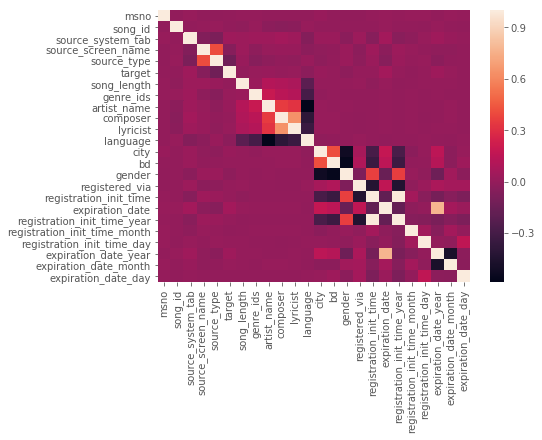

In [11]:
# Сorrelation matrix
plt.figure(figsize=[7,5])
sns.heatmap(df.corr())
plt.show()

In [12]:
# Drop columns
df = df.drop(['expiration_date', 'lyricist'], 1)

## Random Forest

I selected the most informative columns using Random Forest Model.

In [13]:
# Model with the best estimator
model = ensemble.RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(df[df.columns[df.columns != 'target']], df.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
df_plot = pd.DataFrame({'features': df.columns[df.columns != 'target'],
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

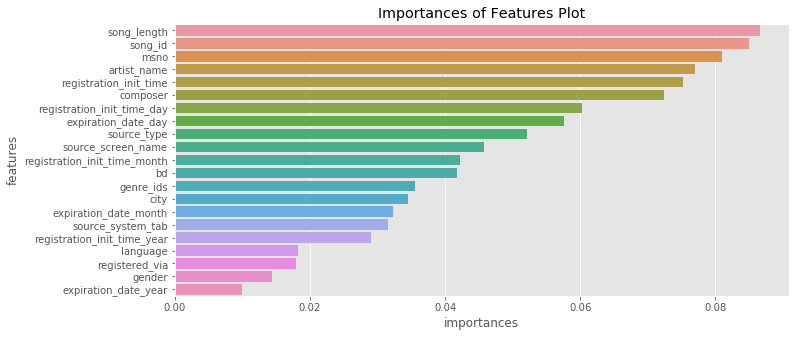

In [15]:
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [16]:
# Drop columns with importances < 0.04
df = df.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)

In [17]:
# Selected columns
df.columns

Index(['msno', 'song_id', 'source_screen_name', 'source_type', 'target',
       'song_length', 'artist_name', 'composer', 'bd',
       'registration_init_time', 'registration_init_time_month',
       'registration_init_time_day', 'expiration_date_day'],
      dtype='object')

## XGboost

In [18]:
# Train & Test split
target = df.pop('target')
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(df, target, test_size = 0.3)

# Delete df
del df

The best estimator was selected by Randomized Grid Search with Stratified Shuffle Split Cross Validation.

\# Create model

model = xgb.XGBClassifier()

\# Create parameters grid

parameters_grid = {
    'learning_rate' : [0.1, 0.2, 0.5],
    'max_depth' : [5, 10, 15],
    'n_estimators' : [150, 250, 300],
    'min_child_weight' : [3, 5, 10]
}

\# Strategy of cross validation

cv = cross_validation.StratifiedShuffleSplit(train_labels, n_iter = 3, test_size = 0.3)

\# Create Grid search Strategy

grid_cv = grid_search.RandomizedSearchCV(model, parameters_grid, scoring = 'accuracy', cv = cv)

\# Fit model by Grid

grid_cv.fit(train_data, train_labels)

\# Model with the best estimator 

grid_cv.best_estimator_

In [19]:
# Create model
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=250)
model.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=15, min_child_weight=5, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [20]:
# Predicting
predict_labels = model.predict(test_data)

## The results of the algorithm

In [21]:
print(metrics.classification_report(test_labels, predict_labels))

             precision    recall  f1-score   support

          0       0.63      0.60      0.61     11129
          1       0.61      0.65      0.63     11004

avg / total       0.62      0.62      0.62     22133

